In [1]:
from pycbc.detector import add_detector_on_earth
import pycbc.psd
import numpy as np

# Set up CE detector locations
lon = -125 / 180.0 * np.pi
lat = 46 / 180.0 * np.pi
yangle = 100.0 / 180.0 * np.pi
add_detector_on_earth("C4", lon, lat, yangle=yangle,
                      xlength=40000, ylength=40000)

add_detector_on_earth("C5", lon, lat, yangle=yangle,
                      xlength=40000, ylength=40000)

add_detector_on_earth("C6", lon, lat, yangle=yangle,
                      xlength=20000, ylength=20000)

lon = -94 / 180.0 * np.pi
lat = 29 / 180.0 * np.pi
yangle = 160.0 / 180.0 * np.pi
add_detector_on_earth("C7", lon, lat, yangle=yangle,
                      xlength=20000, ylength=20000)


networks = [
    ['H1'],
    ['C4'],
    ['H1', 'L1', 'I1'],
    ['C4', 'L1', 'I1'],
    ['C5', 'L1', 'I1'],
    ['C6', 'L1', 'I1'],
    ['C5', 'C7', 'I1'],
    ['C5', 'L1', 'E1', 'E2', 'E3'],
    ['C6', 'L1', 'E1', 'E2', 'E3'],
    ['C5', 'C7', 'E1', 'E2', 'E3'],
]



(1e-25, 1e-22)

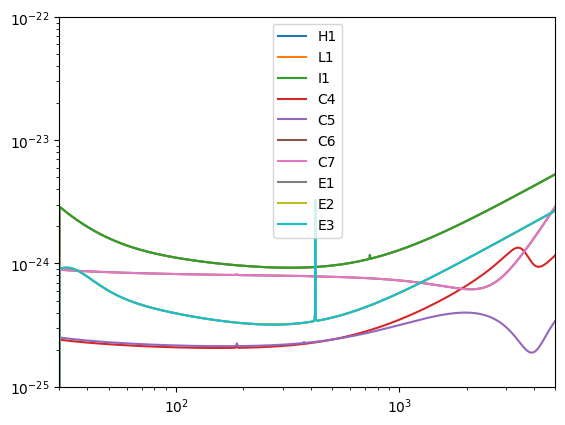

In [2]:
from matplotlib import pyplot as plt

# Set up PSDs
slen = 1
srate = 10000
tlen = slen * srate
flen = tlen // 2 + 1
df = 1.0 / slen
dt = 1.0 / srate
flow = 30.1

asharp = pycbc.psd.from_txt('../ligo_strain/Asharp_strain.txt',
                            flen, df, flow)
ce40 = pycbc.psd.from_txt('../ce_strain/cosmic_explorer_strain.txt',
                         flen, df, flow)
ce20 = pycbc.psd.from_txt('../ce_strain/cosmic_explorer_20km_pm_strain.txt',
                         flen, df, flow)
et = pycbc.psd.from_txt('./et.txt',
                         flen, df, flow)

ce40_disp =  pycbc.psd.from_txt('./cosmic_explorer_displacement.txt',
                         flen, df, flow)
psds = {
    'H1':asharp,
    'L1':asharp,
    'I1':asharp,
    'C4':ce40,
    'C5':ce40_disp / 40000 ** 2.0,
    'C6':ce20,
    'C7':ce20,
    'E1':et,
    'E2':et,
    'E3':et,
}

plt.figure()
for k in psds:
    (psds[k]**0.5).plot(label=k)

plt.xscale('log')
plt.yscale('log')
plt.xlim(30, 5000)
plt.legend()
plt.ylim(1e-25, 1e-22)
    

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.
(0.9986933074278534, 169346)
2.8394952635964612e-21 169346


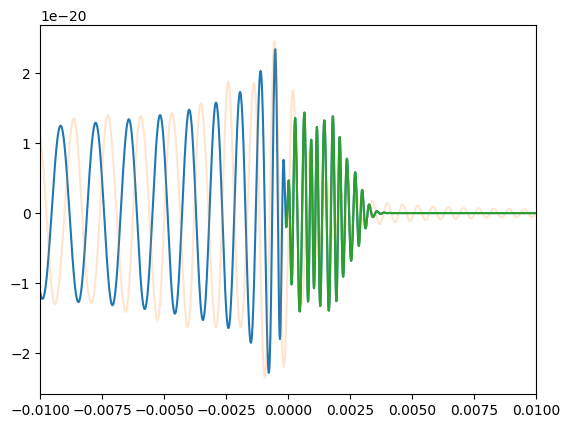

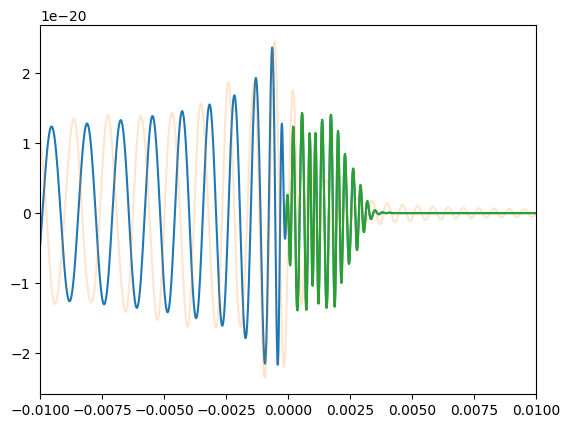

In [3]:
import h5py, lal
from pycbc.types import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter, sigma
from matplotlib import pyplot as plt

f = h5py.File('./data.hdf', 'r')
d = f['rh_22/Rh_l2_m2_r01000.txt'][:]

t = d[:,0] * lal.MTSUN_SI * 2.7

# Data for this one was uniformly samples, not sure if that
# is generic to the format though
dx = t[1] - t[0]
hp = TimeSeries(d[:, 1], delta_t=dx, epoch=t[0])
hc = TimeSeries(d[:, 2], delta_t=dx, epoch=t[0])
hp = hp.time_slice(-1, hp.end_time)
hc = hc.time_slice(-1, hc.end_time)

mt = 1.35
hr, _ = get_td_waveform(approximant="TaylorF2", mass1=mt, mass2=mt,
                        f_lower=150, delta_t=hp.delta_t, distance=1)
mlen = max(len(hp), len(hr))
hr.resize(mlen)

hp.resize(mlen)
hc.resize(mlen)

m2 = hp.match(hr, low_frequency_cutoff=300, high_frequency_cutoff=700)
print(m2)

snr = matched_filter(hp, hr, low_frequency_cutoff=300, high_frequency_cutoff=700)
n = sigma(hp, low_frequency_cutoff=300, high_frequency_cutoff=700)
s, i = snr.abs_max_loc()
print(s, i)

# Align, and normalize
sdif = hp.start_time - hr.start_time
hp.start_time += i * snr.delta_t  - sdif
hc.start_time += i * snr.delta_t  - sdif
hp *= s / n
hc *= s / n

# Pick off postmerger -> VALIDATE THIS VISUALLY!
php = hp.time_slice(-.0001, 0.01)
phc = hc.time_slice(-.0001, 0.01)

plt.figure()
hp.plot()
hr.plot(alpha=0.2)
php.plot()
plt.xlim(-.01, .01)

plt.figure()
hc.plot()
hr.plot(alpha=0.2)
phc.plot()
plt.xlim(-.01, .01)

php = php.to_frequencyseries(delta_f=df)
phc = phc.to_frequencyseries(delta_f=df)

In [4]:
for k in psds:
    sig = sigma(php, psd=psds[k], low_frequency_cutoff=1000,
                  high_frequency_cutoff=4800)
    
    dmax = sig / 5.0
    print(k, dmax)

H1 36.986363711320145
L1 36.986363711320145
I1 36.986363711320145
C4 111.67242687231803
C5 477.6500185701073
C6 133.8254969338883
C7 133.8254969338883
E1 73.8384672779392
E2 73.8384672779392
E3 73.8384672779392


In [15]:
from pycbc.filter import sigma
from pycbc.detector import Detector
from tqdm import trange
from pycbc.distributions import (SinAngle,
                                 UniformSky,
                                 UniformAngle, 
                                 UniformRadius,
                                 Uniform
                                )
import numpy.random
numpy.random.seed(0)
mcsize = int(3000)
sky = UniformSky().rvs(mcsize)
inc = SinAngle(inclination=None).rvs(mcsize)
pol = UniformAngle(polarization=None).rvs(mcsize)
dist = UniformRadius(distance=(1, 100)).rvs(mcsize)
time = 1e10

det = {k: Detector(k) for k in psds.keys()}

snrs = {k: [] for k in psds.keys()}
for i in trange(mcsize):   
    ic = np.cos(inc['inclination'][i])
    ip = 0.5 * (1.0 + ic * ic)

    ant = {}
    for ifo in psds.keys():
        fp, fc = det[ifo].antenna_pattern(sky['ra'][i], sky['dec'][i],
                                 pol['polarization'][i], time)
        
        if ifo == 'C5':
            fp = numpy.ones(len(php)) * (fp + 0.0j)
            fc = numpy.ones(len(php)) * (fc + 0.0j)
            
            block = 25
            freqs = numpy.arange(800, 4800, df * block)
            kmin = int(1000 / df)
            for j, f in enumerate(freqs):
                fpH, fcH = det[ifo].antenna_pattern(sky['ra'][i], sky['dec'][i],
                                                    pol['polarization'][i], time,
                                                    frequency=f)   
                fp[kmin+j * block:kmin+(j+1) * block] = fpH
                fc[kmin+j * block:kmin+(j+1) * block] = fcH             

        ant[ifo] = fp, fc
        
    for ifo in psds.keys():
        fp, fc = ant[ifo]
        pm = fp * php * ip + fc * phc * ic
        snr = sigma(pm, psd=psds[ifo], low_frequency_cutoff=1000,
                    high_frequency_cutoff=4800)
        snrs[ifo].append(snr)
    
for k in snrs:
    snrs[k] = numpy.array(snrs[k])
    
res2 = {}
for network in networks:
    key = ''.join(network)
    nsnr = 0
    for ifo in network:
        nsnr += snrs[ifo]**2.0
    res2[key] = nsnr ** 0.5
    

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:48<00:00, 62.17it/s]


In [26]:
sthresh = 5.0
pm_range = {}
for k in res2:   
    dref = np.array(res2[k]) / sthresh
    rang = ((dref ** 3.0).sum() / len(dref)) ** (1.0 / 3.0) 
    pm_range[k] = rang
    print("%s :  %.1f" % (k,  rang))
    
    
# redshift is all pretty small for these, so can pretty much ignore
# cosmology
rate = 300 / 10**9 # mergers per cubic Mpc per year
for k in pm_range:
    num_per_year = rate *  (4/3 * np.pi * pm_range[k] ** 3.0)
    print("%s : %.3f %.1f " % (k, num_per_year, 1.0 /  num_per_year))

H1 :  16.5
C4 :  49.9
H1L1I1 :  27.8
C4L1I1 :  54.4
C5L1I1 :  56.5
C6L1I1 :  63.6
C5C7I1 :  79.6
C5L1E1E2E3 :  70.4
C6L1E1E2E3 :  76.3
C5C7E1E2E3 :  89.7
H1 : 0.006 177.0 
C4 : 0.156 6.4 
H1L1I1 : 0.027 37.2 
C4L1I1 : 0.202 5.0 
C5L1I1 : 0.227 4.4 
C6L1I1 : 0.323 3.1 
C5C7I1 : 0.634 1.6 
C5L1E1E2E3 : 0.439 2.3 
C6L1E1E2E3 : 0.559 1.8 
C5C7E1E2E3 : 0.906 1.1 
